In [1]:
import gymnasium as gym
import numpy as np
from gymnasium.wrappers import TransformObservation, TimeLimit
import matplotlib.pyplot as plt
from collections import defaultdict

# Tile Coding

In [2]:
def tile_coding(state, num_tilings, tiles_per_dim, state_space_bounds, offset=0.1):
    encoded_state = np.zeros((num_tilings, *([tiles_per_dim] * len(state_space_bounds))))
    
    for tiling in range(num_tilings):
        tile_indices = []
        for i, (s, bounds) in enumerate(zip(state, state_space_bounds)):
            scale = tiles_per_dim / (bounds[1] - bounds[0] + offset * (num_tilings - 1))
            tiling_offset = tiling * offset / tiles_per_dim
            
            tile_index = np.floor(scale * (s - bounds[0] + tiling_offset)).astype(int) % tiles_per_dim
            tile_indices.append(tile_index)
        
        encoded_state[(tiling, *tile_indices)] = 1
    
    return encoded_state.flatten()

# Q-Learning Agent

In [3]:
class QLearningAgent:
    def __init__(self, num_tilings, tiles_per_dim, state_space_bounds, num_actions, alpha, gamma, epsilon):
        self.num_tilings = num_tilings
        self.tiles_per_dim = tiles_per_dim
        self.state_space_bounds = state_space_bounds
        self.num_actions = num_actions
        self.alpha = alpha / num_tilings
        self.gamma = gamma
        self.epsilon = epsilon
        num_features = num_tilings * tiles_per_dim ** len(state_space_bounds)
        self.weights = np.random.uniform(-0.001, 0.001, (num_features, num_actions))
        
    def transform_observation_wrapper(self, state):
        encoded_state = tile_coding(state, self.num_tilings, self.tiles_per_dim, self.state_space_bounds).flatten()
        return encoded_state
    
    def get_q_values(self, state):
        q_values = np.dot(state, self.weights)
        return q_values
    
    def choose_action(self, state, greedy=False):
        if np.random.rand() < self.epsilon and not greedy:
            return np.random.randint(self.num_actions)
        else:
            q_values = self.get_q_values(state)
            return np.argmax(q_values)
    
    def update(self, state, action, reward, next_state, done):
        q_values_current = self.get_q_values(state)
        q_values_next = self.get_q_values(next_state)
        
        q_target = reward + (0 if done else self.gamma * np.max(q_values_next))
        
        q_value = q_values_current[action]
        td_error = q_target - q_value
        self.weights[:, action] += self.alpha * td_error * state


# Expected Sarsa Agent

In [4]:
class ExpectedSarsaAgent:
    def __init__(self, num_tilings, tiles_per_dim, state_space_bounds, num_actions, alpha, gamma, epsilon):
        self.num_tilings = num_tilings
        self.tiles_per_dim = tiles_per_dim
        self.state_space_bounds = state_space_bounds
        self.num_actions = num_actions
        self.alpha = alpha / num_tilings
        self.gamma = gamma
        self.epsilon = epsilon
        num_features = num_tilings * tiles_per_dim ** len(state_space_bounds)
        self.weights = np.random.uniform(-0.001, 0.001, (num_features, num_actions))
        
    def transform_observation_wrapper(self, state):
        encoded_state = tile_coding(state, self.num_tilings, self.tiles_per_dim, self.state_space_bounds).flatten()
        return encoded_state
    
    def get_q_values(self, state):
        q_values = np.dot(state, self.weights)
        return q_values
    
    def choose_action(self, state, greedy=False):
        if np.random.rand() < self.epsilon and not greedy:
            return np.random.randint(self.num_actions)
        else:
            q_values = self.get_q_values(state)
            return np.argmax(q_values)
    
    def get_action_probabilities(self, q_values):
        # Implementing ε-greedy policy to get action probabilities
        policy = np.ones(self.num_actions) * self.epsilon / self.num_actions
        best_action = np.argmax(q_values)
        policy[best_action] += (1.0 - self.epsilon)
        return policy
    
    def update(self, state, action, reward, next_state, done):
        q_values_current = self.get_q_values(state)
        q_values_next = self.get_q_values(next_state)
        
        # Instead of taking the max of q_values_next, we take the expected Q value under the policy
        action_probabilities = self.get_action_probabilities(q_values_next)
        expected_q_value_next = np.dot(action_probabilities, q_values_next)
        
        q_target = reward + (0 if done else self.gamma * expected_q_value_next)
        
        q_value = q_values_current[action]
        td_error = q_target - q_value
        self.weights[:, action] += self.alpha * td_error * state


# Testing

## Mountain Car

In [5]:
mc_num_tilings = 4
mc_tiles_per_dim = 5
mc_bounds=[(-1.2, 0.6), (-0.07, 0.07)]
mc_num_actions = 3

In [6]:
alpha = 0.1
gamma = 1.0
epsilon = 0.1

# env = gym.make("MountainCar-v0", render_mode="human")
env = gym.make("MountainCar-v0")
agent = QLearningAgent(mc_num_tilings, mc_tiles_per_dim, mc_bounds, mc_num_actions, alpha, gamma, epsilon)
env = TransformObservation(env, agent.transform_observation_wrapper)
for episode in range(2):
    observation, _ = env.reset()
    done = False

    while not done:
        action = agent.choose_action(observation)
        new_observation, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.update(observation, action, reward, new_observation, done)
        observation = new_observation

In [7]:
alpha = 0.1
gamma = 1.0
epsilon = 0.1

# env = gym.make("MountainCar-v0", render_mode="human")
env = gym.make("MountainCar-v0")
agent = ExpectedSarsaAgent(mc_num_tilings, mc_tiles_per_dim, mc_bounds, mc_num_actions, alpha, gamma, epsilon)
env = TransformObservation(env, agent.transform_observation_wrapper)
for episode in range(2):
    observation, _ = env.reset()
    done = False

    while not done:
        action = agent.choose_action(observation)
        new_observation, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.update(observation, action, reward, new_observation, done)
        observation = new_observation

## CartPole

In [8]:
cp_num_tilings = 4
cp_tiles_per_dim = 5
cp_bounds=[(-2.4, 2.4), (-np.inf, np.inf), (-0.5, 0.5), (-np.inf, np.inf)]
cp_practical_bounds = [(-2.4, 2.4), (-5.0, 5.0), (-0.418, 0.418), (-5.0, 5.0)]
cp_num_actions = 2

In [9]:
def clip_state(state, bounds):
    clipped_state = np.clip(state, [b[0] for b in bounds], [b[1] for b in bounds])
    return clipped_state

In [10]:
alpha = 0.1
gamma = 1.0
epsilon = 0.1

# env = gym.make("CartPole-v1", render_mode="human")
env = gym.make("CartPole-v1")
agent = QLearningAgent(cp_num_tilings, cp_tiles_per_dim, cp_practical_bounds, cp_num_actions, alpha, gamma, epsilon)
env = TransformObservation(env, lambda state : agent.transform_observation_wrapper(clip_state(state, cp_practical_bounds)))
# env = TransformObservation(env, agent.transform_observation_wrapper)
for episode in range(2):
    observation, _ = env.reset()
    done = False

    while not done:
        action = agent.choose_action(observation)
        new_observation, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.update(observation, action, reward, new_observation, done)
        observation = new_observation

In [11]:
alpha = 0.1
gamma = 1.0
epsilon = 0.1

# env = gym.make("CartPole-v1", render_mode="human")
env = gym.make("CartPole-v1")
agent = ExpectedSarsaAgent(cp_num_tilings, cp_tiles_per_dim, cp_practical_bounds, cp_num_actions, alpha, gamma, epsilon)
env = TransformObservation(env, lambda state : agent.transform_observation_wrapper(clip_state(state, cp_practical_bounds)))
for episode in range(2):
    observation, _ = env.reset()
    done = False

    while not done:
        action = agent.choose_action(observation)
        new_observation, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.update(observation, action, reward, new_observation, done)
        observation = new_observation

In [12]:
def run_experiment(env_name, AgentClass, num_tilings, num_tiles, practical_bounds, num_actions, alpha, gamma, epsilon, num_runs, num_episodes, max_episode_steps, offset=0.1):
    # Store the rewards for each run
    run_rewards = defaultdict(lambda: [])
    test_run_rewards = defaultdict(lambda: [])
    env = gym.make(env_name)
    env = TimeLimit(env, max_episode_steps=max_episode_steps)
    agent = AgentClass(num_tilings, num_tiles, practical_bounds, num_actions, alpha, gamma, epsilon)
    env = TransformObservation(env, lambda state : agent.transform_observation_wrapper(clip_state(state, practical_bounds)))


    for run in range(num_runs):
        agent = AgentClass(num_tilings, num_tiles, practical_bounds, num_actions, alpha, gamma, epsilon)
        total_rewards = []

        for episode in range(num_episodes):
            observation, _ = env.reset()
            done = False
            total_reward = 0

            while not done:
                action = agent.choose_action(observation)
                new_observation, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                agent.update(observation, action, reward, new_observation, done)
                observation = new_observation
                total_reward += reward
            
            observation, _ = env.reset()
            done = False
            test_total_reward = 0
            while not done:
                action = agent.choose_action(observation, greedy=True)
                new_observation, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                observation = new_observation
                test_total_reward += reward

            total_rewards.append(total_reward)
        run_rewards['Run {}'.format(run + 1)] = total_rewards
    env.close()

    return run_rewards, test_run_rewards

In [13]:
env_variables = {
    'MountainCar-v0': {
        'num_tilings': 4,
        'num_tiles': 10,
        'offset': 0.2,
        'bounds': [(-1.2, 0.6), (-0.07, 0.07)],
        'practical_bounds': [(-1.2, 0.6), (-0.07, 0.07)],
        'num_actions': 3,
        'max_episode_steps': 10000
    },
    'CartPole-v1': {
        'num_tilings': 4,
        'num_tiles': 10,
        'offset': 0.2,
        'bounds': [(-2.4, 2.4), (-np.inf, np.inf), (-0.5, 0.5), (-np.inf, np.inf)],
        'practical_bounds': [(-2.4, 2.4), (-5.0, 5.0), (-0.418, 0.418), (-5.0, 5.0)],
        'num_actions': 2,
        'max_episode_steps': 5000
    }
}



In [14]:
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures

# Define the parameters
epsilon_values = [1/4, 1/8, 1/16]
step_size = 1/4  # Assuming we still use a fixed step size
num_runs = 50
num_episodes = 1000
env_names = ['MountainCar-v0', 'CartPole-v1']

# Define Agent classes
agents = [QLearningAgent, ExpectedSarsaAgent]  # Example agent classes

# Initialize a data structure to store the results
all_results = {
    env_name: {
        epsilon: {
            agent.__name__: [] for agent in agents
        } for epsilon in epsilon_values
    } for env_name in env_names
}

all_test_results = {
    env_name: {
        epsilon: {
            agent.__name__: [] for agent in agents
        } for epsilon in epsilon_values
    } for env_name in env_names
}

# Function to run an experiment
def run_single_experiment(env_name, epsilon, agent):
    print(f"Running experiments for {env_name} with epsilon={epsilon} and agent={agent.__name__}")
    env_vars = env_variables[env_name]
    rewards, test_rewards = run_experiment(
        env_name, agent, env_vars['num_tilings'], env_vars['num_tiles'],
        env_vars['practical_bounds'], env_vars['num_actions'], step_size, 1, epsilon,
        num_runs, num_episodes, env_vars['max_episode_steps']
    )
    return env_name, epsilon, agent.__name__, rewards, test_rewards

# Run the experiment for each combination of environment, epsilon, and agent in parallel
with ThreadPoolExecutor(max_workers=12) as executor:
    futures = []
    for env_name in env_names:
        for epsilon in epsilon_values:
            for agent in agents:
                futures.append(executor.submit(run_single_experiment, env_name, epsilon, agent))

    # Wait for all tasks to complete and store the results
    for future in concurrent.futures.as_completed(futures):
        env_name, epsilon, agent_name, rewards, test_rewards = future.result()
        all_results[env_name][epsilon][agent_name] = rewards
        all_test_results[env_name][epsilon][agent_name] = test_rewards


Running experiments for MountainCar-v0 with epsilon=0.25 and agent=QLearningAgent
Running experiments for MountainCar-v0 with epsilon=0.25 and agent=ExpectedSarsaAgent
Running experiments for MountainCar-v0 with epsilon=0.125 and agent=QLearningAgent
Running experiments for MountainCar-v0 with epsilon=0.125 and agent=ExpectedSarsaAgent
Running experiments for MountainCar-v0 with epsilon=0.0625 and agent=QLearningAgent
Running experiments for MountainCar-v0 with epsilon=0.0625 and agent=ExpectedSarsaAgent
Running experiments for CartPole-v1 with epsilon=0.25 and agent=QLearningAgent
Running experiments for CartPole-v1 with epsilon=0.25 and agent=ExpectedSarsaAgent
Running experiments for CartPole-v1 with epsilon=0.125 and agent=QLearningAgent
Running experiments for CartPole-v1 with epsilon=0.125 and agent=ExpectedSarsaAgent
Running experiments for CartPole-v1 with epsilon=0.0625 and agent=QLearningAgent
Running experiments for CartPole-v1 with epsilon=0.0625 and agent=ExpectedSarsaAgen

Plotting results for MountainCar-v0 with epsilon=0.25 and agent=QLearningAgent
(50, 1000)


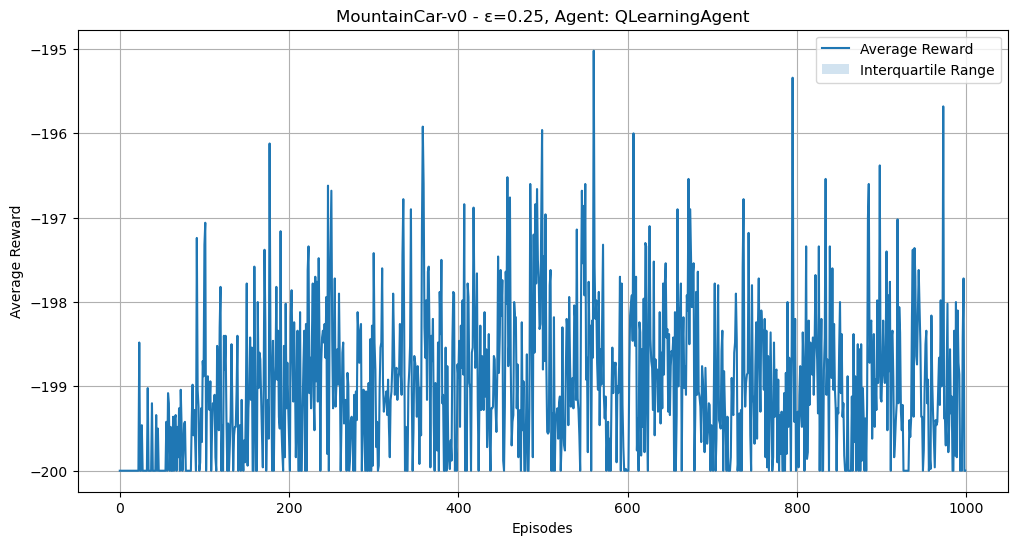

Plotting results for MountainCar-v0 with epsilon=0.25 and agent=ExpectedSarsaAgent
(50, 1000)


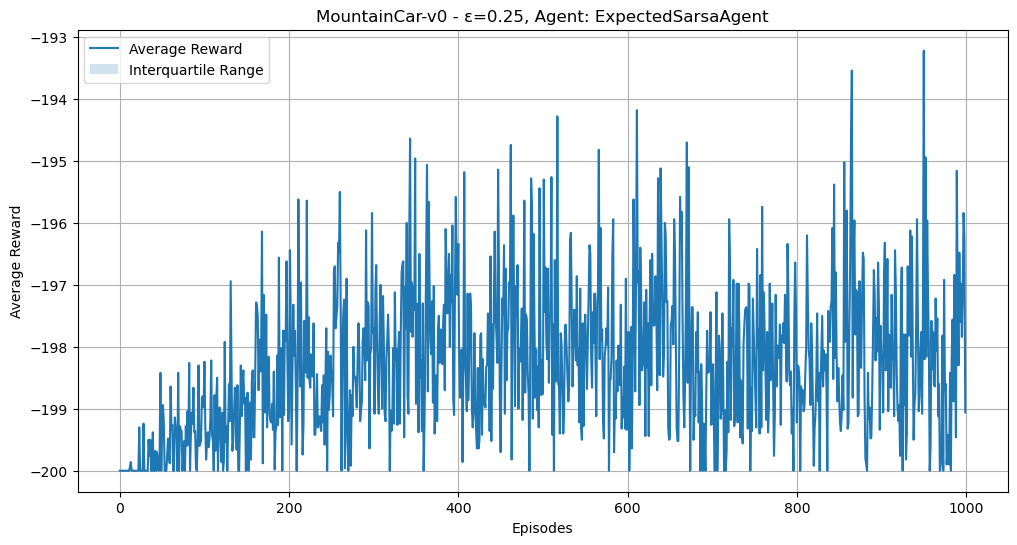

Plotting results for MountainCar-v0 with epsilon=0.125 and agent=QLearningAgent
(50, 1000)


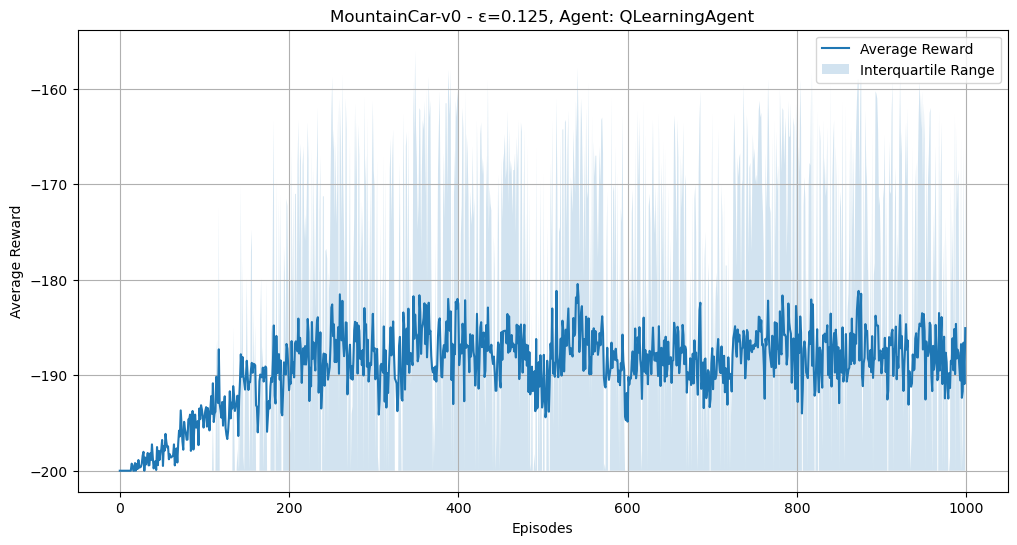

Plotting results for MountainCar-v0 with epsilon=0.125 and agent=ExpectedSarsaAgent
(50, 1000)


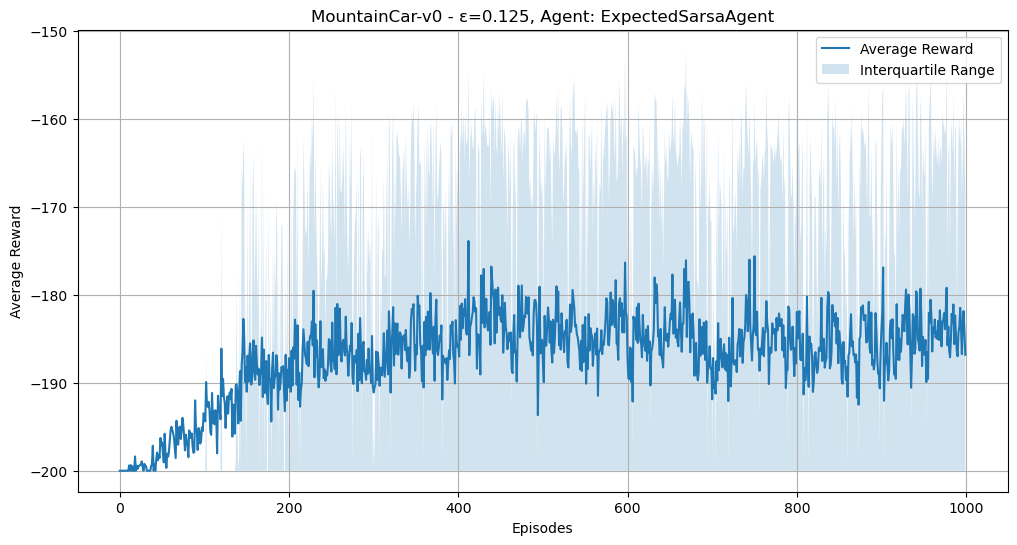

Plotting results for MountainCar-v0 with epsilon=0.0625 and agent=QLearningAgent
(50, 1000)


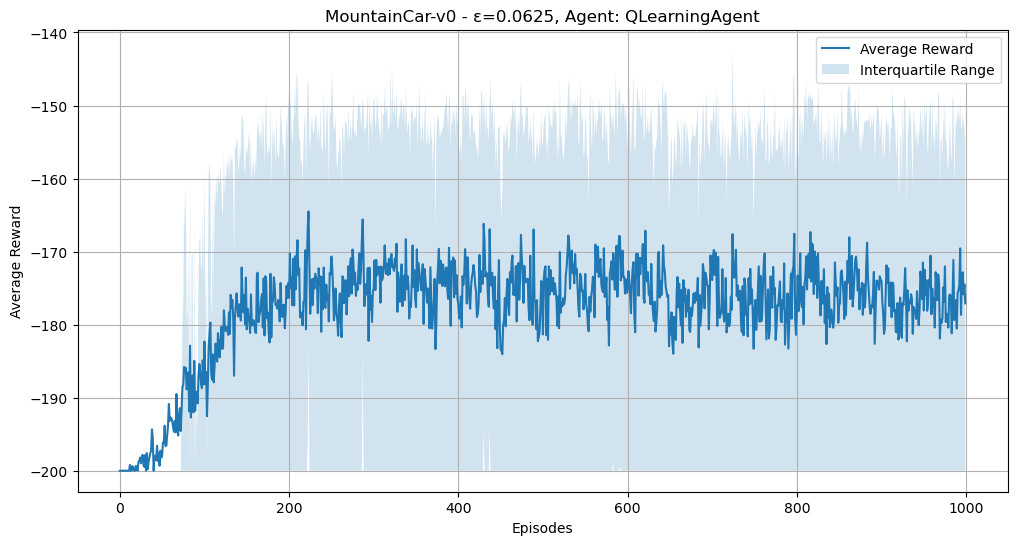

Plotting results for MountainCar-v0 with epsilon=0.0625 and agent=ExpectedSarsaAgent
(50, 1000)


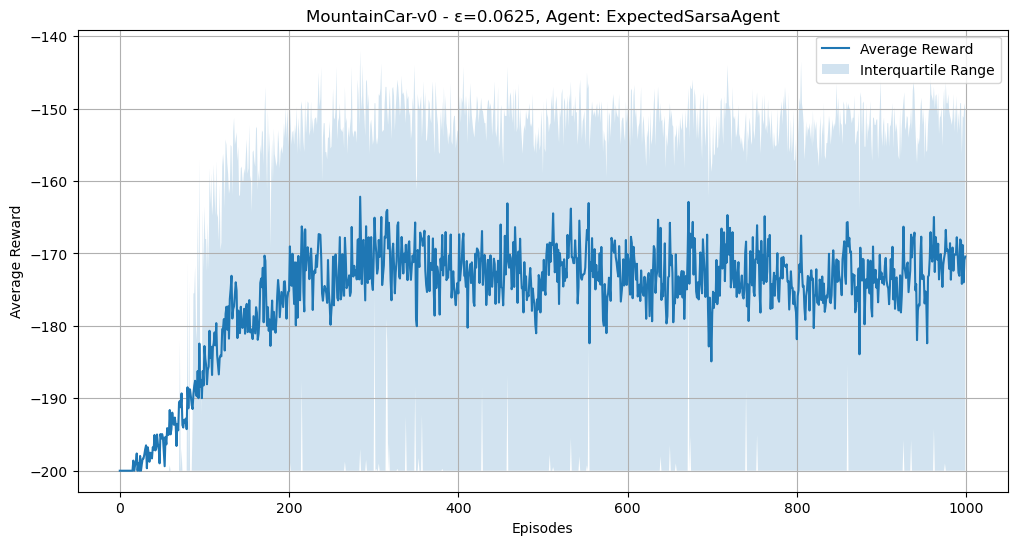

Plotting results for CartPole-v1 with epsilon=0.25 and agent=QLearningAgent
(50, 1000)


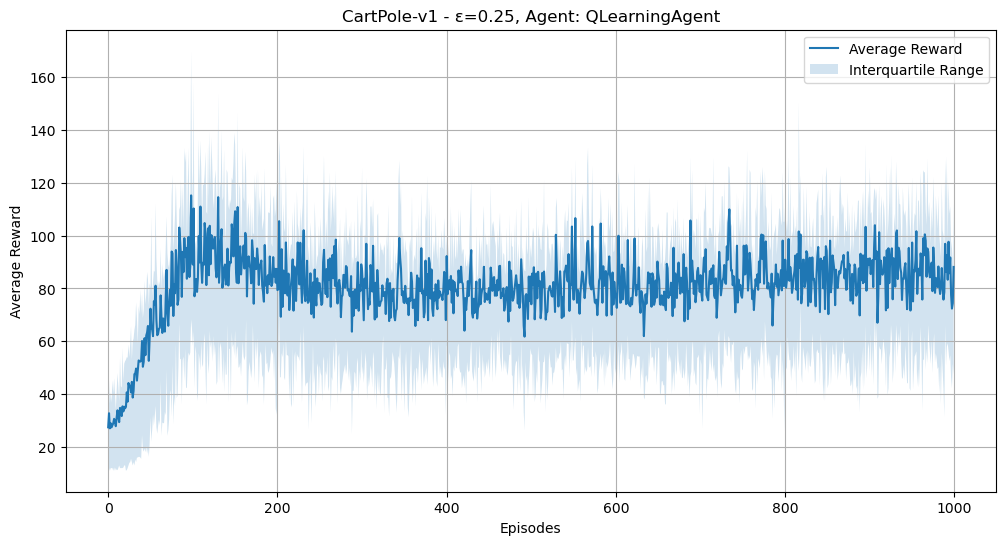

Plotting results for CartPole-v1 with epsilon=0.25 and agent=ExpectedSarsaAgent
(50, 1000)


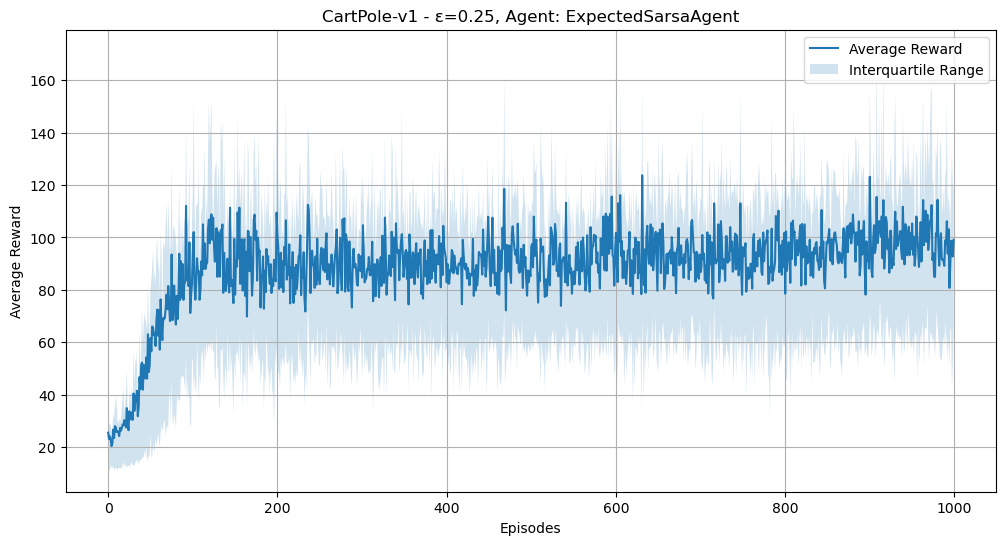

Plotting results for CartPole-v1 with epsilon=0.125 and agent=QLearningAgent
(50, 1000)


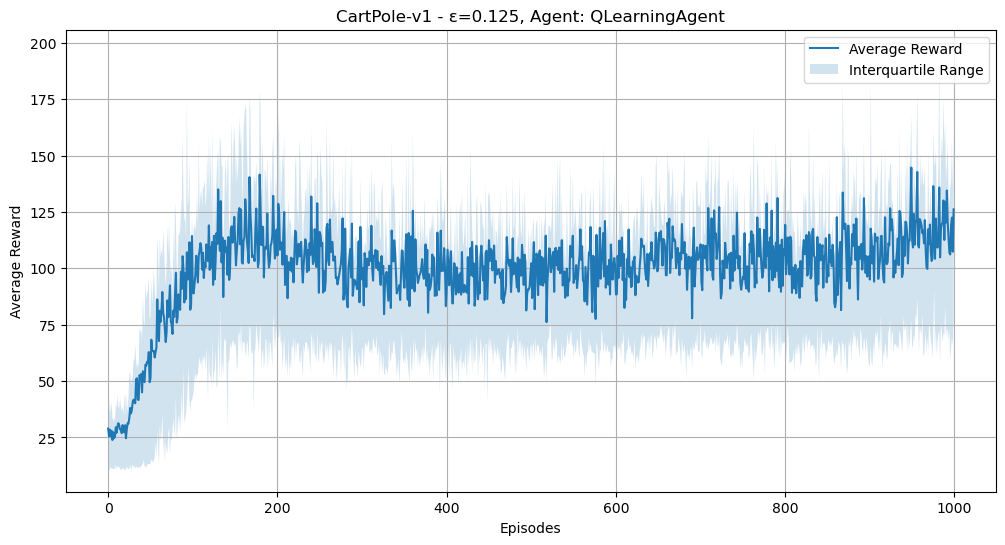

Plotting results for CartPole-v1 with epsilon=0.125 and agent=ExpectedSarsaAgent
(50, 1000)


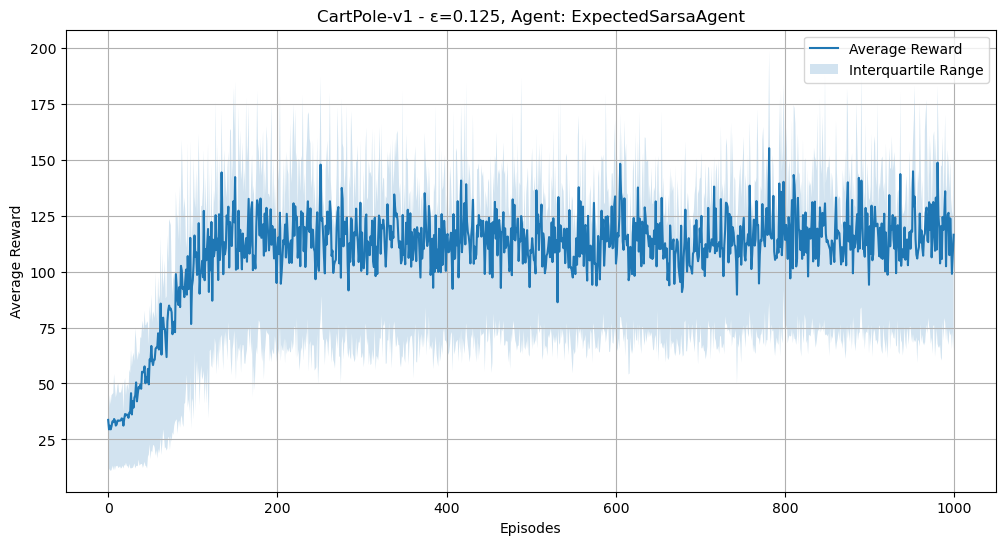

Plotting results for CartPole-v1 with epsilon=0.0625 and agent=QLearningAgent
(50, 1000)


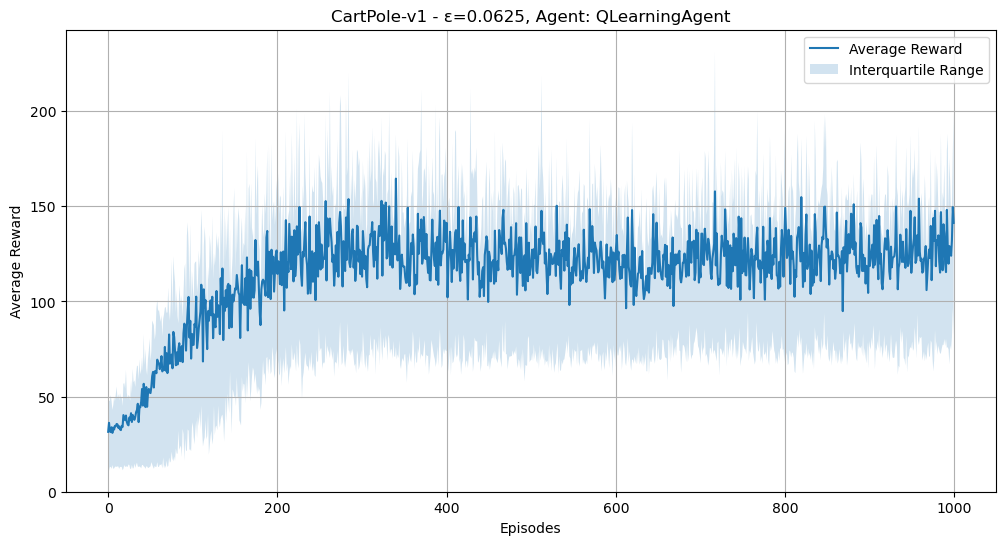

Plotting results for CartPole-v1 with epsilon=0.0625 and agent=ExpectedSarsaAgent
(50, 1000)


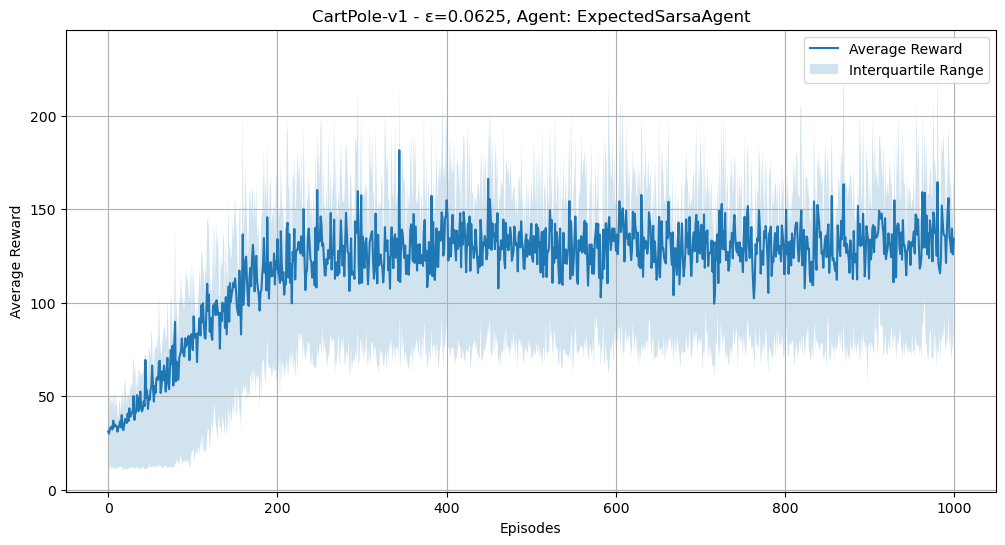

In [15]:
# Plot the results
for env_name in env_names:
    for epsilon in epsilon_values:
        for agent in agents:
            agent_name = agent.__name__
            reward_lists = all_results[env_name][epsilon][agent_name].values()
            reward_lists = np.array(list(reward_lists))
            print(f"Plotting results for {env_name} with epsilon={epsilon} and agent={agent_name}")
            print(reward_lists.shape)

            # Assuming 'reward_lists' is already a complete list of rewards
            if len(reward_lists) < 2:
                raise ValueError("Not enough complete runs to calculate statistics.")

            # Convert the list of reward lists into a 2D NumPy array
            rewards_array = np.array(reward_lists)

            # Calculate the mean and percentiles along the first axis
            avg_rewards = np.mean(rewards_array, axis=0)
            lower_quartile = np.percentile(rewards_array, 25, axis=0)
            upper_quartile = np.percentile(rewards_array, 75, axis=0)

            # Plotting the average performance with interquartile range
            plt.figure(figsize=(12, 6))
            plt.plot(avg_rewards, label='Average Reward')
            plt.fill_between(range(num_episodes), lower_quartile, upper_quartile, alpha=0.2, label='Interquartile Range')
            plt.title(f'{env_name} - ε={epsilon}, Agent: {agent_name}')
            plt.xlabel('Episodes')
            plt.ylabel('Average Reward')
            plt.legend()
            plt.grid(True)
            plt.savefig(f'{env_name}_epsilon_{epsilon}_agent_{agent_name}.png')
            plt.show()


In [16]:
# Plot the results
for env_name in env_names:
    for epsilon in epsilon_values:
        for agent in agents:
            agent_name = agent.__name__
            reward_lists = all_test_results[env_name][epsilon][agent_name].values()
            reward_lists = np.array(list(reward_lists))
            print(f"Plotting results for {env_name} with epsilon={epsilon} and agent={agent_name}")
            print(reward_lists.shape)

            # Assuming 'reward_lists' is already a complete list of rewards
            if len(reward_lists) < 2:
                raise ValueError("Not enough complete runs to calculate statistics.")

            # Convert the list of reward lists into a 2D NumPy array
            rewards_array = np.array(reward_lists)

            # Calculate the mean and percentiles along the first axis
            avg_rewards = np.mean(rewards_array, axis=0)
            lower_quartile = np.percentile(rewards_array, 25, axis=0)
            upper_quartile = np.percentile(rewards_array, 75, axis=0)

            # Plotting the average performance with interquartile range
            plt.figure(figsize=(12, 6))
            plt.plot(avg_rewards, label='Average Reward')
            plt.fill_between(range(num_episodes), lower_quartile, upper_quartile, alpha=0.2, label='Interquartile Range')
            plt.title(f'{env_name} - ε={epsilon}, Agent: {agent_name}')
            plt.xlabel('Episodes')
            plt.ylabel('Average Reward')
            plt.legend()
            plt.grid(True)
            plt.savefig(f'{env_name}_epsilon_{epsilon}_agent_{agent_name}_test.png')
            plt.show()


Plotting results for MountainCar-v0 with epsilon=0.25 and agent=QLearningAgent
(0,)


ValueError: Not enough complete runs to calculate statistics.